In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics
from matplotlib.pylab import rcParams
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, roc_curve, ConfusionMatrixDisplay, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder ,StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score

In [2]:
df = pd.read_csv('insurance.csv')

<h2>Exploratory Data Analysis and data preparation<h2/>

We can see that there are 1338 records in the table and there are no nulls in the table. Data seems to be clean.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Mean charges varies from median which suggests that charges' distribution is not normal. Charges are in general high values - these are anual amounts. When it comes to BMI, children and BMI, mean is close to the median. At first sight, we may say that there are no outliers (seeing min and max values).

In [4]:
df.describe()

age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

In [87]:
df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [88]:
#regions are quite evenly distributed
df['region'].value_counts().to_frame()

count
region          
southeast    364
southwest    325
northwest    325
northeast    324

In [5]:
#cleaning the index
df.reset_index(inplace=True)
df.set_index('index', inplace=True)

In [6]:
#some columns require transformation in order to be comprehensible by models. 
#There are only two labels in "smoker" and "children" columns, that's why I decided to use the label encoder
labelencoder = LabelEncoder()

In [7]:
df['sex'] = labelencoder.fit_transform(df['sex'])
df['smoker'] = labelencoder.fit_transform(df['smoker'])
#I'm using the pandas get_dummies method which will create a column for each region
df = pd.get_dummies(data=df, columns=['region'])

In [8]:
df

age  sex     bmi  children  smoker      charges  region_northeast  \
index                                                                      
0       19    0  27.900         0       1  16884.92400                 0   
1       18    1  33.770         1       0   1725.55230                 0   
2       28    1  33.000         3       0   4449.46200                 0   
3       33    1  22.705         0       0  21984.47061                 0   
4       32    1  28.880         0       0   3866.85520                 0   
...    ...  ...     ...       ...     ...          ...               ...   
1333    50    1  30.970         3       0  10600.54830                 0   
1334    18    0  31.920         0       0   2205.98080                 1   
1335    18    0  36.850         0       0   1629.83350                 0   
1336    21    0  25.800         0       0   2007.94500                 0   
1337    61    0  29.070         0       1  29141.36030                 0   

       region_northwest  region_southeast  region_southwest  
index                                                        
0                     0                 0                 1  
1                     0                 1                 0  
2                     0                 1                 0  
3                     1                 0                 0  
4                     1                 0                 0  
...                 ...               ...               ...  
1333                  1                 0                 0  
1334                  0                 0                 0  
1335                  0                 1                 0  
1336                  0                 0                 1  
1337                  1                 0                 0  

[1338 rows x 10 columns]

I decided to add another column, which would classify BMI values. This is just a transformation for the purpose of EDA.

In [98]:
bmi = pd.DataFrame(
    [
    {"BMI": "< 18.5", "Condition": "Underweight"},
    {"BMI": "18.5 - 24.9", "Condition": "Healthy weight"},
    {"BMI": "25.0 - 29.9", "Condition": "Overweight"},
    {"BMI": "35 > X > 30", "Condition": "Obesity, class 1"},
    {"BMI": "40 > X > 35", "Condition": "Obesity, class 2"},
    {"BMI": "< 40", "Condition": "Obesity, class 3"}
    ]
)
bmi

BMI         Condition
0       < 18.5       Underweight
1  18.5 - 24.9    Healthy weight
2  25.0 - 29.9        Overweight
3  35 > X > 30  Obesity, class 1
4  40 > X > 35  Obesity, class 2
5         < 40  Obesity, class 3

In [99]:
conditions = [
    (df['bmi'] >= 0) & (df['bmi'] < 25),
    (df['bmi'] >= 25) & (df['bmi'] < 30),
    (df['bmi'] >= 30) & (df['bmi'] < 35),
    (df['bmi'] >=35) & (df['bmi'] < 40),
    (df['bmi'] >= 40) & (df['bmi'] < 45),
    (df['bmi'] >= 45)
]

results = ['Underweight', 'Healthy weight', 'Overweight', 'Obesity, class 1', 'Obesity, class 2', 'Obesity, class 3']

df['BMI'] = np.select(conditions, results)

We can see that the majority class is "overweight". There are less people with healthy weight. There are almost twice as many people that weigh too much. Our dataset comes from the USA, where obesity is a huge social problem.

In [100]:
df['BMI'].value_counts().to_frame()

count
BMI                    
Overweight          391
Healthy weight      386
Underweight         245
Obesity, class 1    225
Obesity, class 2     71
Obesity, class 3     20

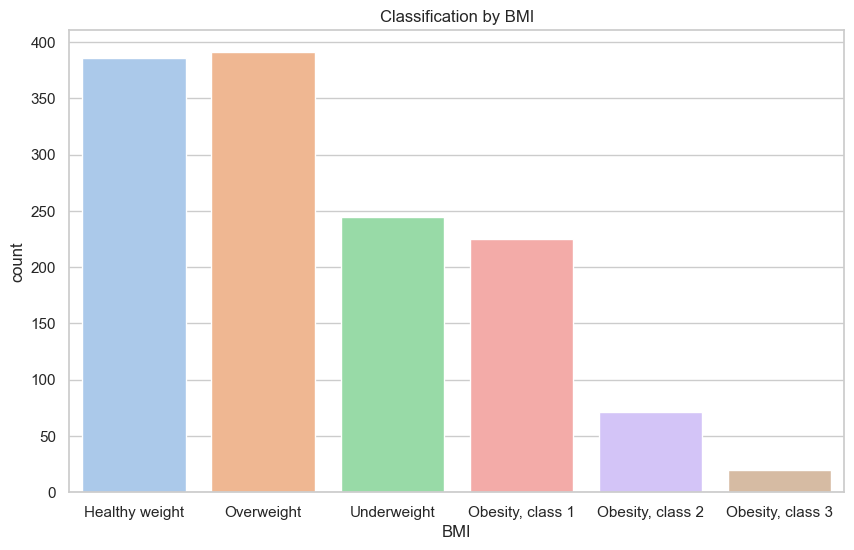

In [101]:
plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid", palette="pastel")
sns.countplot(x=df['BMI'])
plt.title('Classification by BMI')

plt.show();

In [102]:
df['smoker'].value_counts().to_frame()

count
smoker       
0        1064
1         274

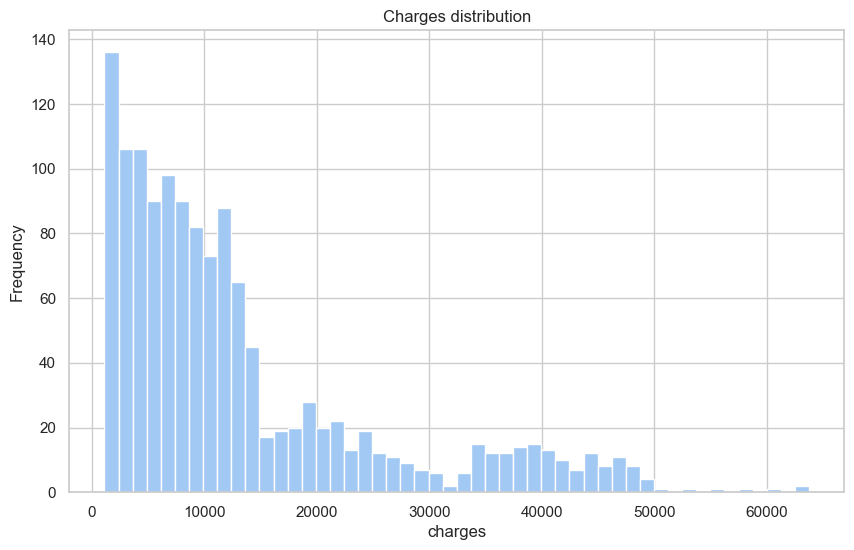

In [103]:
plt.figure(figsize=(10,6))
df['charges'].plot(kind='hist', bins=50)
plt.xlabel('charges')
plt.title('Charges distribution')
plt.show()

In [106]:
nosmoke = df[df['smoker']==0]
smoke = df[df['smoker']==1]

In [107]:
nosmoke['charges']

index
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1064, dtype: float64

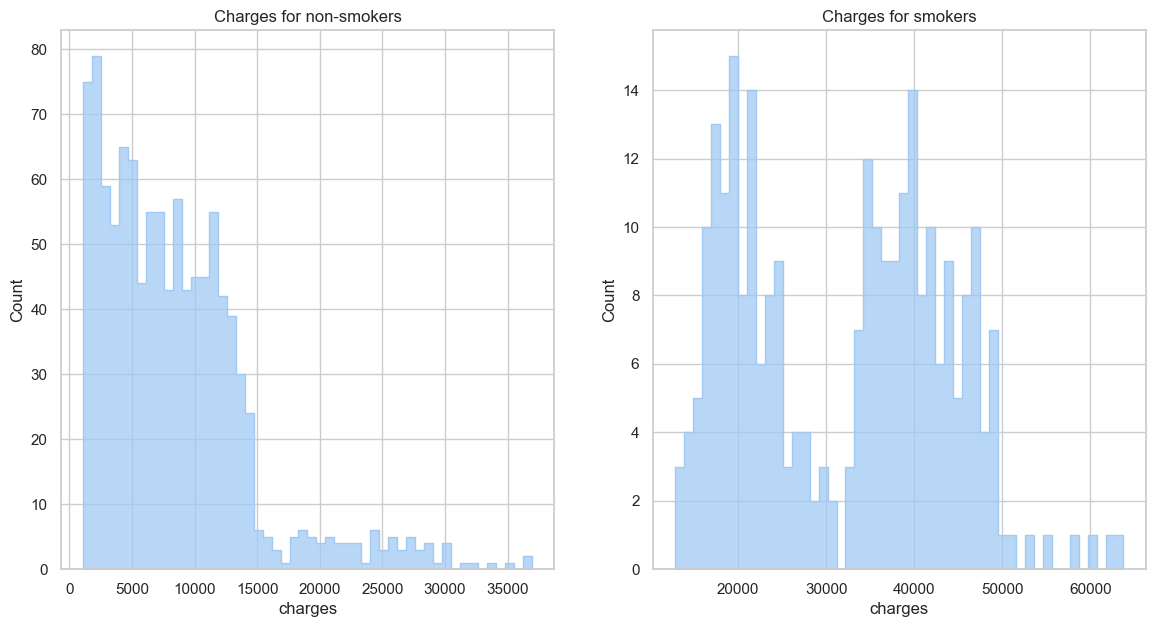

In [108]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
sns.histplot(nosmoke['charges'], ax=axes[0], bins=50, element="step")
axes[0].set_title('Charges for non-smokers')
sns.histplot(x='charges', data=smoke, ax=axes[1], bins=50, element="step")
axes[1].set_title('Charges for smokers')
plt.style.use('seaborn-deep')
plt.show()

Charges range for people that smoke is much higher. The distribution is different - for non-smokers the distribution is right-skewed that is a distribution common for financial data (majority of low values). Whereas for smokers, the distribution is irregualar (has almost two peaks). This can of course be caused by the scarcity of data for smokers.
Zakres opłat dla osób palących papierosy jest dużo wyższy. Ich rozkłas się różni. Dla osób niepalących mamy rozkład prawoskośny, czyli rozkład częsty dla danych finansowych - przewaga wartości niskich. Jednak dla palaczy jest to rozkład bardziej nieregularny, niemalże o dwóch peakach (ale też jest mniej danych).

In [109]:
df['sex'].value_counts().to_frame('Count')

Count
sex       
1      676
0      662

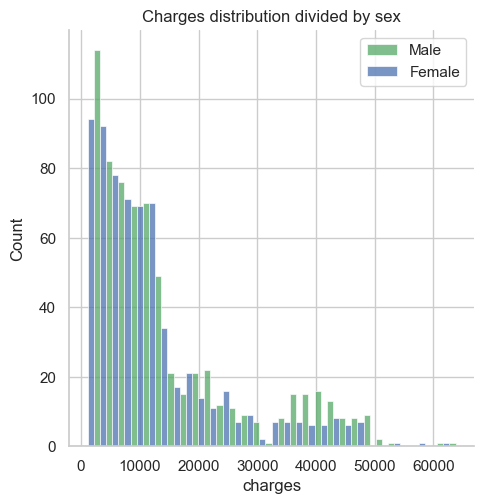

In [110]:
sns.displot(df, x='charges', hue='sex', multiple='dodge', legend=False)
plt.title('Charges distribution divided by sex')
plt.legend(['Male','Female'])

plt.show()

There are no major differences between charges for women and men.

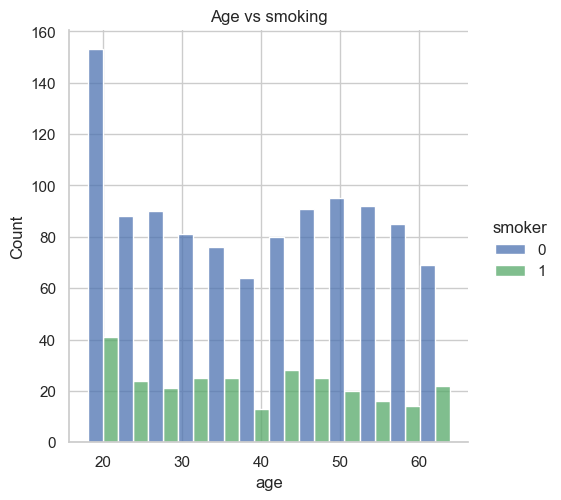

In [111]:
sns.displot(df, x='age', hue='smoker', multiple='dodge')
plt.title('Age vs smoking')

plt.show()

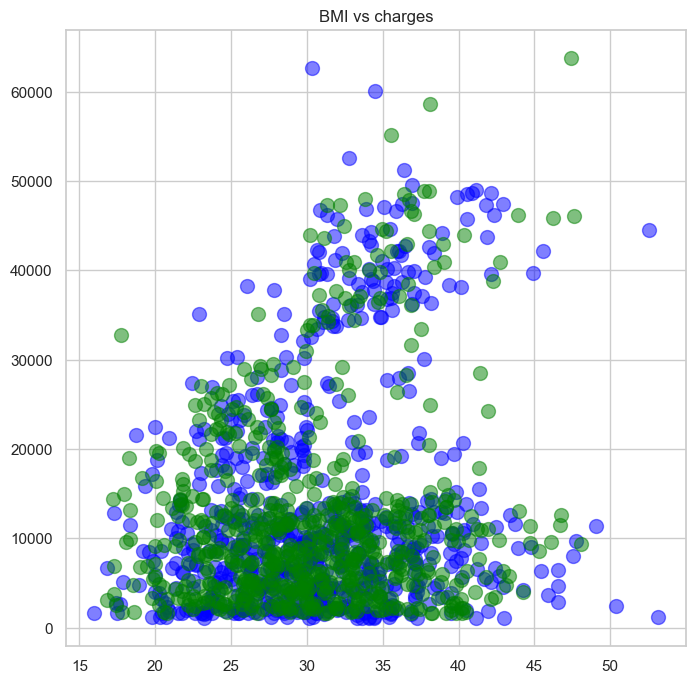

In [113]:
female = df[df['sex']==0]
male = df[df['sex']==1]
plt.scatter(male['bmi'], male['charges'],s=100, color='blue', alpha=0.5)
plt.scatter(female['bmi'], female['charges'],s=100, color='green', alpha=0.5)
plt.title('BMI vs charges')
plt.show()

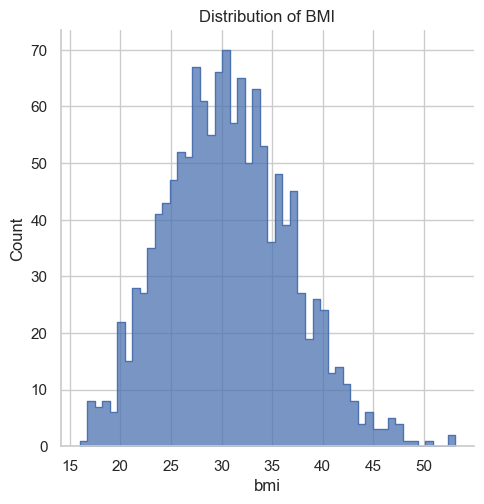

In [114]:
sns.displot(df, x='bmi',element='step', bins=50)
plt.title('Distribution of BMI')
plt.show()

BMI has a normal distribution. The peak is around 30.

In [115]:
df['children'].value_counts().to_frame()

count
children       
0           574
1           324
2           240
3           157
4            25
5            18

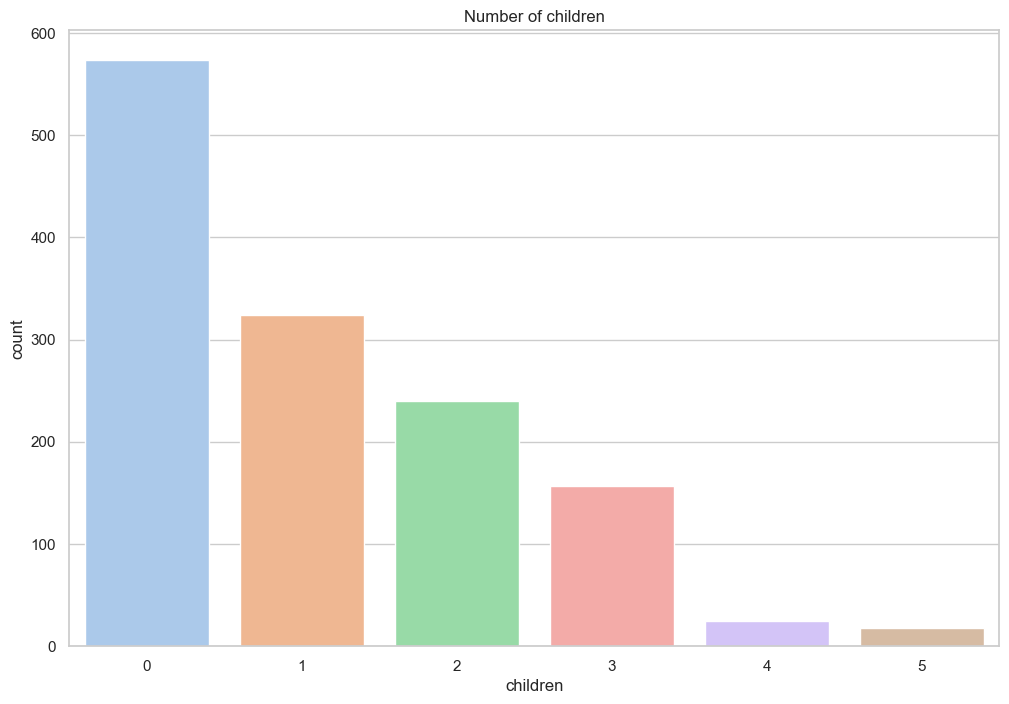

In [116]:
plt.figure(figsize=(12,8))
sns.set_theme(style="whitegrid", palette="pastel")
sns.countplot(x=df['children'])
plt.title('Number of children')

plt.show();

There is a majority of people with no children. There are very few people with 3+ children.

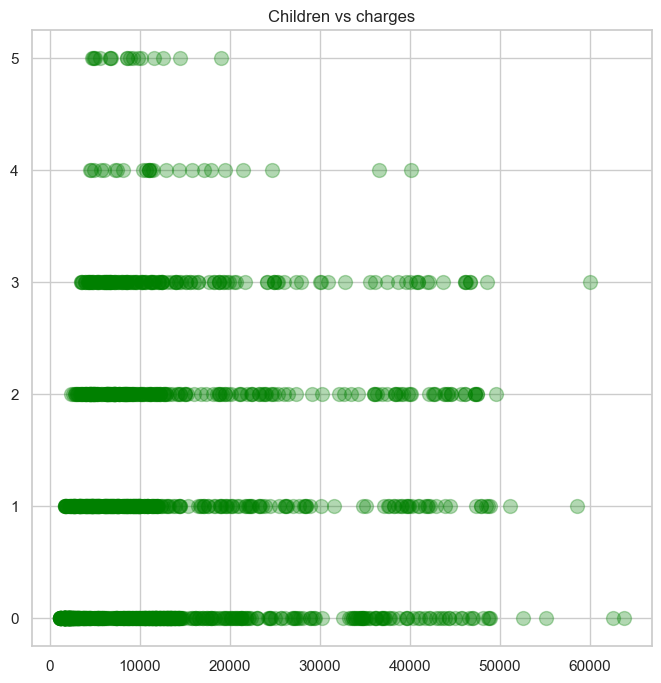

In [117]:
plt.scatter(df['charges'], df['children'],s=100, color='green', alpha=0.3)
plt.title('Children vs charges')
plt.show()

As we can see on the heatmap below, there is no high correlation between variables. The correlation is highest between age, bmi and charges. There is also slight correlation between region southeast and bmi. 

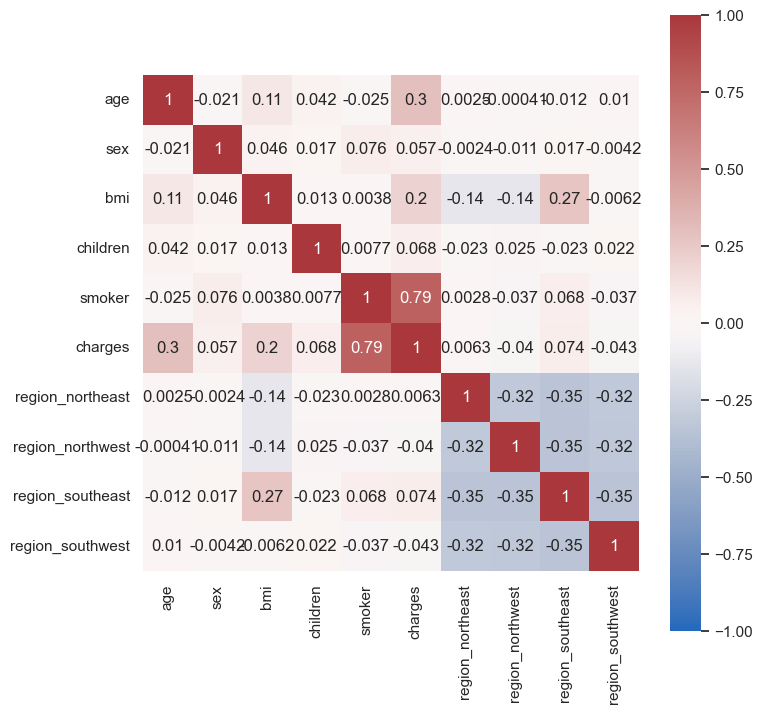

In [12]:
Pearson_correlation_matrix = df.corr(method='pearson')

sns.set(rc={'figure.figsize':(8,8)}) 

sns.heatmap(
    Pearson_correlation_matrix,
    cmap='vlag',
    vmin=-1.,
    vmax=1., 
    square=True,
    annot=True
    ) 

pass

I decided to also check Spearman correlation (which determines non-linear relationship between variables), because some of the variables are logical. We may observe that correlation between charges and age is higher here.

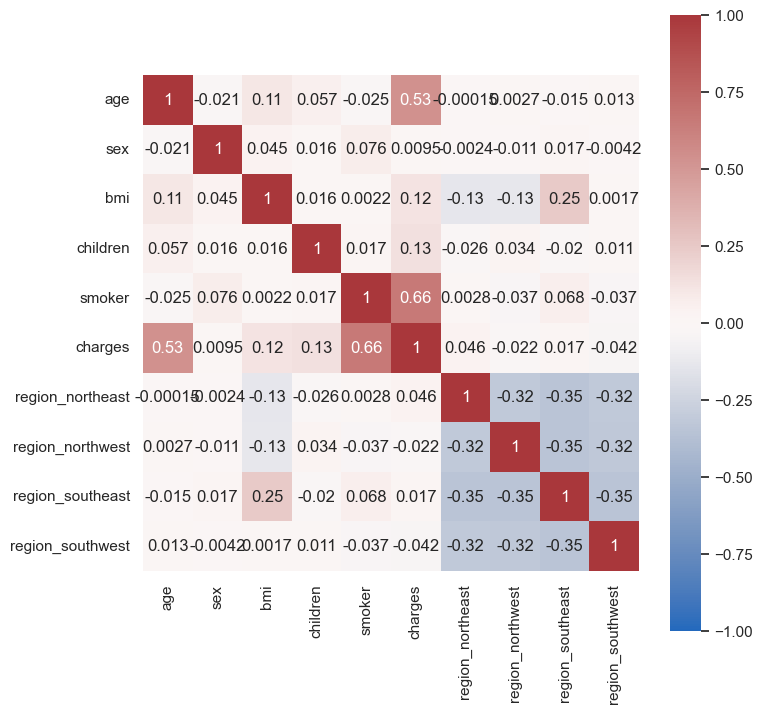

In [10]:
Spearman_correlation_matrix = df.corr(method='spearman')

sns.set(rc={'figure.figsize':(8,8)}) 

sns.heatmap(
    Spearman_correlation_matrix,
    cmap='vlag',
    vmin=-1.,
    vmax=1., 
    square=True,
    annot=True
    ) 

pass

<h2>Modelling<h2/>

<h3>xgboost<h3/>

First I decided to check how will the XGBoost model perform with our data. XGBoost is often referred to as "state-of-the-art" for tabular data.

In [119]:
y = df['charges']
colx = ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
x = df[colx]

In [123]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [124]:
xg_reg = xgb.XGBRegressor(
    random_state=123, 
    n_estimators=20, 
    max_depth=6,
    subsample=0.5,
    colsample_bytree=1,
)

In [125]:
params= {
'n_estimators': range(1,50,5),
'max_depth': range(1,8,2),
'subsample': [0, 0.1, 0.25,0.5, 0.75, 1],
'colsample_bytree': [0, 0.1, 0.25,0.5, 0.75, 1],
'eta': [0, 0.1, 0.25,0.5, 0.75, 1],
}

In [126]:
from sklearn.model_selection import GridSearchCV

Parameters tuning took quite a long time. The model below is fitted with the best params.

In [ ]:
xg_search = GridSearchCV(xg_reg, params, cv=5)
xg_search.fit(x_train, y_train)

In [ ]:
xg_search.best_params_

In [ ]:
xg_search.best_score_

In [127]:
xg_reg = xgb.XGBRegressor(
    random_state=123, 
    n_estimators=46, 
    max_depth=3,
    subsample=0.75,
    colsample_bytree=1,
    eta=0.1
)

In [128]:
xg_reg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=46, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [129]:
y_pred = xg_reg.predict(x_test)


In [130]:
xg_reg.score(x_test, y_test) 

0.9013025555780656

In [131]:
xg_reg.score(x_train, y_train)

0.873795081665234

The model is well balanced, the score on train and test is quite close.

In [133]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
print("RMSE - gbtree: ", rmse)
print("MAE - gbtree: ", mae)

RMSE - gbtree:  3963.0443616180364
MAE - gbtree:  2371.057726134328


Our model is mistaken by 2370 dollars on average. The mean of charges was over 13000 dollars, so the error is not high.


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

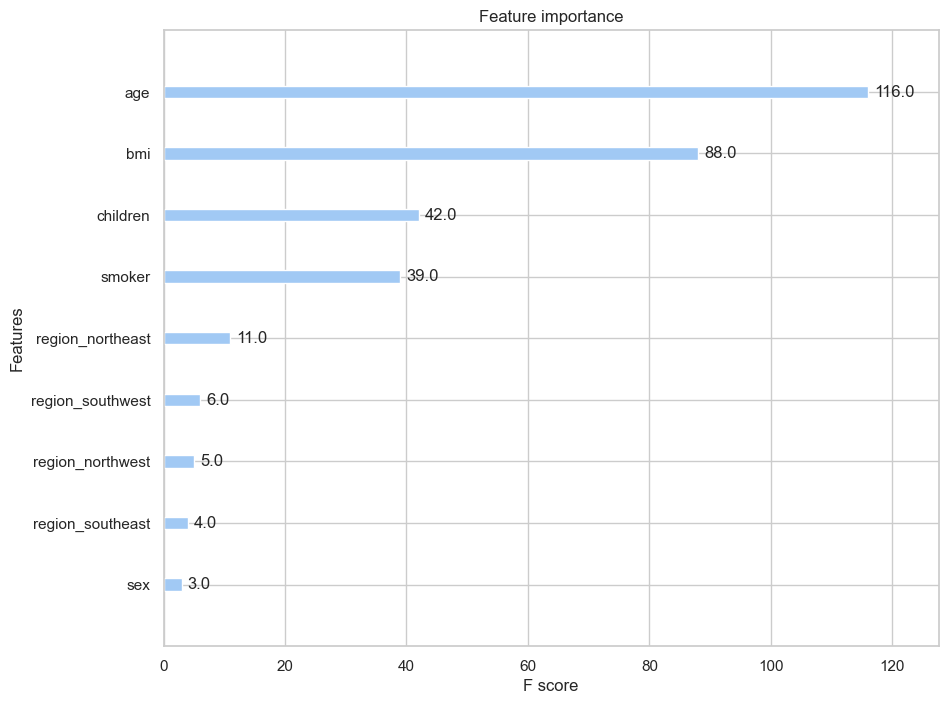

In [134]:
rcParams['figure.figsize'] = 10, 8

xgb.plot_importance(xg_reg)

What is interesting, the most important variable for the model came out to be age, which has in fact correlated with charges, but not as strong as smoking which is on the third place.


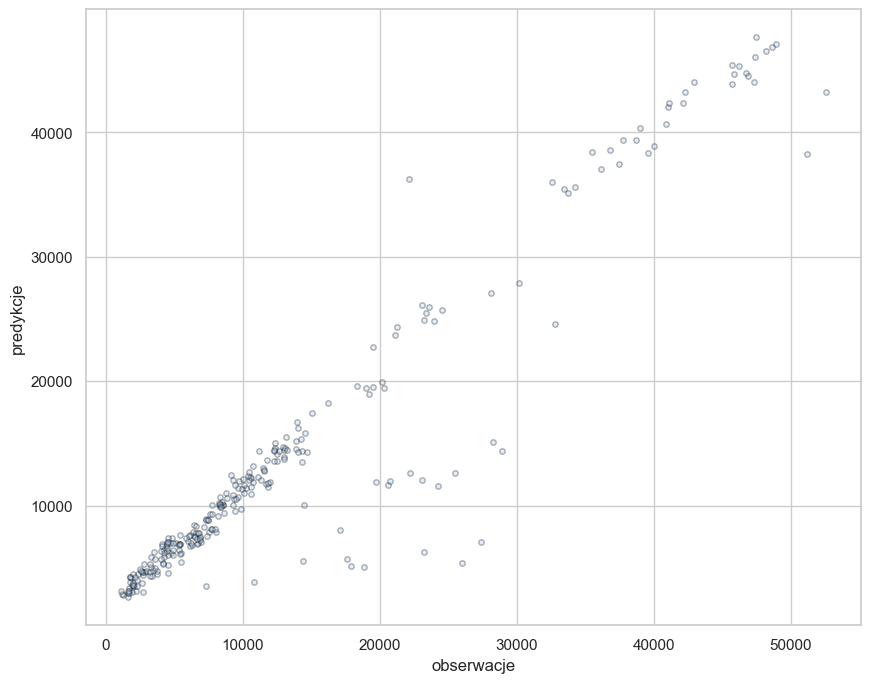

In [135]:
plt.scatter(
    y_test,
    y_pred,
    edgecolor="black",
    s=15, 
    alpha = 0.3)
plt.xlabel("obserwacje")
plt.ylabel("predykcje");

In the ideal situation, the observations and predictions would be on one line, but we can see that the deviation is not high.


In [ ]:
from sklearn.metrics import r2_score

In [136]:
r2_score(y_test, y_pred)

0.9013025555780656

In [140]:
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

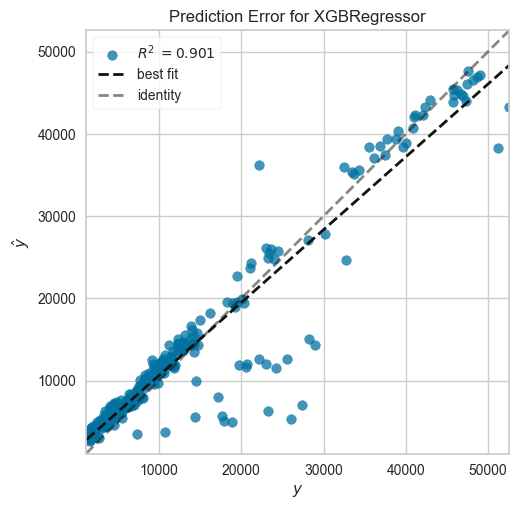

In [141]:
prediction_error(xg_reg, x_train, y_train, x_test, y_test);

R^2 wynosi 83%, czyli nasz model uwzględnia taki procent wariancji dla zbioru.    
Czarna linia oznaczałaby najlepszy model, który najlepiej przewiduje kwoty. Nasz model jest dosyć blisko tej linii.

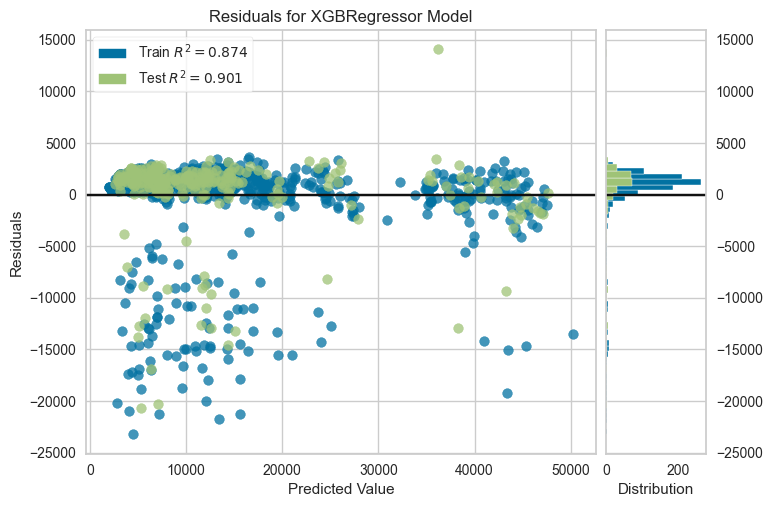

In [142]:
residuals_plot(xg_reg, x_train, y_train, x_test, y_test);

Wnioski z wykresu? rozkład normalny reszt. Reszty są skupione głównie wokół 0, czyli model zazwyczaj mało się myli.  
Pozostała część reszt jest rozproszona, te mocniej odstające są częściej ujemne. 

Chciałam sprawdzić czy standaryzacja i PCA pomogą tutaj usprawnić model

Wniosek: PCA nie pomogło zwiększyć efektywności modelu.

XGBOOST
R^2 0.8452188534851794
RMSE - gbtree:  4986.577318902035
MAE - gbtree:  2579.3158939387536

In [170]:
def znajdz_najlepszy_model_gridsearchcv(X,y): 
    algos = {

        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
               
                'splitter': ['best','random'],
                'max_depth': range(1,10),
                'min_samples_leaf':range(1,4)
            }
            
        },
        'randomforest_regressor':{
            'model':RandomForestRegressor(),
            'params':{
                'n_estimators':[150]
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

znajdz_najlepszy_model_gridsearchcv(x,y)

model  best_score   
0           decision_tree    0.880719  \
1  randomforest_regressor    0.869172   

                                         best_params  
0  {'max_depth': 5, 'min_samples_leaf': 3, 'split...  
1                              {'n_estimators': 150}

In [157]:
rf=RandomForestRegressor(n_estimators=150)
rf.fit(x_train, y_train)
rf_scores = cross_val_score(rf, x_train, y_train, scoring='r2', cv = 5)
print("Accuracy score dla Random forest: ", rf_scores)
print("Average accuracy score dla Randam forest: ", rf_scores.mean())

Accuracy score dla Random forest:  [0.8495849  0.8259809  0.7983521  0.82308667 0.77367882]
Average accuracy score dla Randam forest:  0.8141366768989066


In [158]:
y_pred = rf.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2) Score:', r2)

Root Mean Squared Error (RMSE): 4351.814068227313
Mean Absolute Error (MAE): 2571.2745701315284
R-squared (R2) Score: 0.8809885617512777


Miary  Random forest  XGBoost
0  RMSE        4674.84  4986.58
1   MAE        2507.64  2579.31
2   R^2           0.87     0.85

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [146]:
lr = LinearRegression()
lr.fit(x_train, y_train)
lr.score(x_test,y_test)

0.7999876970680433

In [147]:
y_pred = lr.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2) Score:', r2)

Root Mean Squared Error (RMSE): 5641.62655885019
Mean Absolute Error (MAE): 3933.272649405234
R-squared (R2) Score: 0.7999876970680433


In [167]:
dt = DecisionTreeRegressor(splitter='best', max_depth=5, min_samples_leaf=3)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2) Score:', r2)

Root Mean Squared Error (RMSE): 4101.894863733905
Mean Absolute Error (MAE): 2496.393621850626
R-squared (R2) Score: 0.8942654090556071


In [172]:
miary_tab = pd.DataFrame({'Miary':['RMSE','MAE', 'R^2'],
                         'Random forest': [4674.84, 2507.64, 0.87],
                         'XGBoost': [3963.04, 2371.06, 0.90],
                         'Linear Regression': [5641.63, 3933.27, 0.799],
                         'Decision Tree': [4101.89, 2496.39, 0.89]})
miary_tab

Miary  Random forest  XGBoost  Linear Regression  Decision Tree
0  RMSE        4674.84  3963.04           5641.630        4101.89
1   MAE        2507.64  2371.06           3933.270        2496.39
2   R^2           0.87     0.90              0.799           0.89